##### Кузнецова Юлия, гр. 3530202/80201

## Автокодировщики
#### Реализуйте на основе автокодировщика алгоритм, выявляющий картинки, которые не содержат рукописные цифры. Использовать датасеты: MNIST и fashion MNIST

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import datasets, layers, models, losses

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

mnist = tf.keras.datasets.mnist

(digits_train, digits_train_labels), (digits_test, digits_test_labels) = tf.keras.datasets.mnist.load_data()
digits_train_norm, digits_test_norm = digits_train / 255.0, digits_test / 255.0

(fashion_train, _), (fashion_test, _) = fashion_mnist.load_data()
fashion_train_norm, fashion_test_norm = fashion_train / 255.0, fashion_test / 255.0

Используем класс автокодировщика из [туториала](https://www.tensorflow.org/tutorials/generative/autoencoder)

In [2]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim) 

In [3]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(digits_train_norm, digits_train_norm, 
          epochs=20, 
          batch_size=512,
          validation_data=(digits_test_norm, digits_test_norm),
          shuffle=True)

Epoch 1/20
118/118 [==============================] - 2s 9ms/step - loss: 0.0793 - val_loss: 0.0459
Epoch 2/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0379 - val_loss: 0.0314
Epoch 3/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0281 - val_loss: 0.0241
Epoch 4/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0220 - val_loss: 0.0193
Epoch 5/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0180 - val_loss: 0.0160
Epoch 6/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0151 - val_loss: 0.0136
Epoch 7/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0130 - val_loss: 0.0118
Epoch 8/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0113 - val_loss: 0.0103
Epoch 9/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0100 - val_loss: 0.0091
Epoch 10/20
118/118 [==============================] - 1s 7ms/step - loss: 0.0089 - val_loss: 0.0082

Теперь, когда модель обучена, протестируем ее путем кодирования и декодирования изображений из тестового набора

In [4]:
encoded_imgs = autoencoder.encoder(digits_test_norm).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

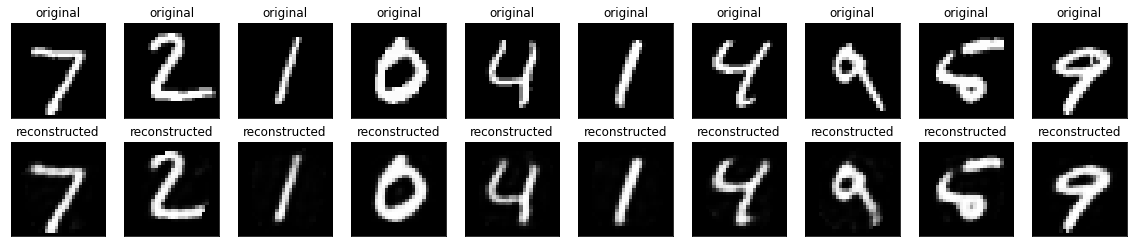

In [5]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(digits_test_norm[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Построим ошибку реконструкции на нормальных цифрах из обучающей выборки.

In [6]:
reconstructions = autoencoder.predict(digits_train_norm)
train_loss = tf.keras.losses.mae(reconstructions, digits_train_norm)

a=0
for i in range(len(train_loss)):
  a+=np.mean(train_loss[i]) + np.std(train_loss[i])
print(a/len(train_loss))

0.04390048331036389


Определим критерий(пороговое значение) для распознавания изображений с цифрами.
Выберем пороговое значение, которое на три стандартных отклонения выше среднего.

In [7]:
threshold = np.mean(train_loss) + 3*np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.09150140684911426


Теперь необходимо проверить выполнение нашего критерия на выборке из 3000 изображений-аномалий(в нашем случае - изображений одежды)

In [8]:
print('Size of dataset with anomalies: ', len(fashion_train_norm[0:3000]))

count = 0

for f in fashion_train_norm[0:3000]:
  pred = autoencoder.predict(np.array([f]))[0]
  loss = tf.keras.losses.mae(pred, f)

  th = float(np.mean(loss) + np.std(loss))

  if th > threshold:
    count += 1

print('Successfully detected anomalies: ', count)

Size of dataset with anomalies:  3000
Successfully detected anomalies:  2981


Проверим наш критерий на выборке из 3000 изображений цифр.

In [9]:
print('Size of dataset with digits: ', len(digits_test_norm[0:3000]))

count = 0

for d in digits_test_norm[0:3000]:
  pred = autoencoder.predict(np.array([d]))[0]
  loss = tf.keras.losses.mae(pred, d)

  th = float(np.mean(loss) + np.std(loss))

  if th < threshold:
    count += 1

print('Successfully detected digits: ', count)

Size of dataset with digits:  3000
Successfully detected digits:  2993
